In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np
from matplotlib.patches import Circle

In [ ]:
 # I used gimp as suggested to randomly select 6 points from the calibration-rig.jpg
image_points = [
    [794,884],
    [842,882],
    [794,950],
    [844,950],
    [1034,882],
    [1034,946]
    ]

[[794, 884], [842, 882], [794, 950], [844, 950], [1034, 882], [1034, 946]]


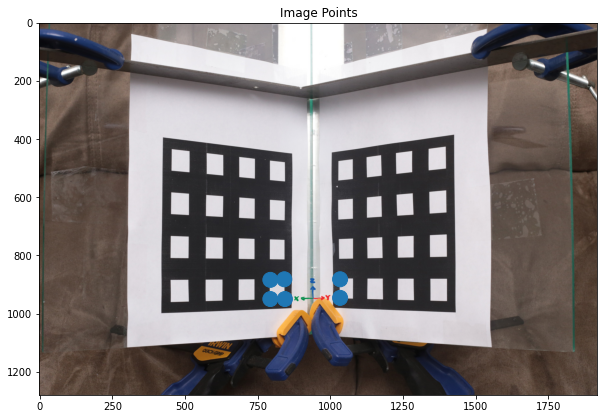

In [ ]:
# code to display the selected points on the image

print(image_points)
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('calibration-rig.jpg')
img = plt.imshow(img)

area = (15 * np.ones(N))**2

plt.scatter(image_points[:,0], image_points[:,1], s=area)
plt.title('Image Points')
plt.show()


In [ ]:
# 3-d co-ordinates as given the figure 2
realw_coord = [(6,0,2),(4,0,2),(6,0,0),(4,0,0),(0,4,2),(0,4,0)]
realw_coord = np.array(realw_coord)
camera_coord = np.array(image_points)

In [ ]:
def camera_calib(camera_coord,realw_coord):

    assert camera_coord.shape == realw_coord.shape[:-1] + (2,)
    n = camera_coord.shape[0]

    # homogeneous co-ordinates
    Xh = np.hstack((realw_coord, np.ones((n, 1))))
    xh = np.hstack((camera_coord, np.ones((n, 1))))

    # Direct Linear Transformation (DLT)
    A = np.zeros((2 * n, 12))
    for i in range(n):
        A[2 * i, :] = np.hstack((np.zeros(4), -Xh[i, :], xh[i, 1] * Xh[i, :]))
        A[2 * i + 1, :] = np.hstack((Xh[i, :], np.zeros(4), -xh[i, 0] * Xh[i, :]))

    m, r, Vt = np.linalg.svd(A)
    p = Vt[-1, :]
    P = p.reshape((3, 4))
    return P


In [ ]:
P = camera_calib(camera_coord,realw_coord)
print(P)

[[-1.04625000e-02  3.96024238e-02 -1.30715406e-03  7.06125995e-01]
 [ 1.05626637e-02  2.12294921e-02 -2.77875248e-02  7.05954385e-01]
 [ 1.10912530e-05  2.31928152e-05 -1.17362874e-06  7.43246209e-04]]


In [ ]:
def regenerate_points(P, X_world):
    X = np.array(X_world)
    Xnew = np.hstack((X, np.ones((X.shape[0], 1))))
    x = P @ Xnew.T
    xtranspose = x.T

    xnew = xtranspose[:, 0] / xtranspose[:, 2]
    ynew = xtranspose[:, 1] / xtranspose[:, 2]
    xnew = xnew.reshape((xnew.shape[0], 1))
    ynew = ynew.reshape((ynew.shape[0], 1))

    coordinates = np.hstack((xnew, ynew))
    # print(coordinates.shape)
    return coordinates

In [ ]:
coordinates = regenerate_points(P,realw_coord)
print("The reprojected coordinates are:\n\n ", coordinates)

The reprojected coordinates are:

  [[ 793.53456864  883.9661136 ]
 [ 842.59779733  882.03460546]
 [ 794.46280276  950.03251019]
 [ 843.40595511  949.96747113]
 [1033.88770347  882.000212  ]
 [1034.11199002  945.9997933 ]]


In [ ]:
def calc_error(P,realw_coord,camera_coord):

    coordinate  = regenerate_points(P,realw_coord)
    error = np.sum((coordinate-camera_coord)**2)/coordinate.shape[0]

    return error


In [ ]:
error = calc_error(P,realw_coord,camera_coord)
print("Error in image coordinates = ",error)

Error in image coordinates =  0.1951128252648522


In [ ]:
# code to compute intrinsic and extrinsic parameters

import scipy.linalg

def parameters_calc(P):
    holder = P[:, 0:3]

    #Calculate the decomposition A = R Q where Q is unitary/orthogonal and R
    #upper triangular.
    K, R = scipy.linalg.rq(holder)

    Trans = np.diag(np.sign(np.diag(K)))

    if scipy.linalg.det(Trans) < 0:
        Trans[1, 1] *= -1

    K = np.dot(K, Trans)
    Rot = np.dot(Trans, R)

    Center = np.dot(scipy.linalg.inv(-holder), P[:, 3])
    return K, Rot, Center


K,Rot,Center = parameters_calc(P)

print("The K matrix is:\n" , K)
print("\nThe rotation matrix is:\n" , Rot)
print("\nThe camera center is at:\n" , Center)


The K matrix is:
 [[ 2.65200226e-02  4.85655908e-04  3.12406316e-02]
 [ 0.00000000e+00 -2.66799489e-02  2.49517146e-02]
 [ 0.00000000e+00  0.00000000e+00  2.57351894e-05]]

The rotation matrix is:
 [[-0.90233494  0.43081269 -0.01385967]
 [ 0.00715632  0.04712331  0.99886344]
 [ 0.43097616  0.9012102  -0.04560405]]

The camera center is at:
 [-19.13277112 -22.8630658    0.6654095 ]
